Beams: [ 927.28689232  188.37621839   39.97541645] (arcsec^2)
px/beam: [ 33.64306185  47.0940546   25.58426653] (pixels)
Uncertainty per px: [ 0.24136833  0.01748631  0.01779328] mJy
Working on source C1+2
Initial L: 9.345961954855219e-245
Converged in 81295 steps
Acceptance: 2500, rate : 0.030752198782212928
---------
Results for source C1+2
Max Likelihood: 0.005904623912400061
alpha: -1.9360165759194923 +- 0.3573370618591919
MAP alpha: -1.9909021930789113
S14: 0.5485176390620397 + 0.3855335515206805 - 0.22640295905773367 mJy
MAP S14: 0.5240585364834475 mJy
(lognormal) S147MHz: 42.69508715466196 + 15.139790773519998 - 11.176554870254275 mJy
(lognormal) S322MHz: 9.400614185052053 + 1.0928023671796705 - 0.9789960575026271 mJy
(lognormal) S608MHz: 2.7567636839899223 + 0.7775566216697456 - 0.6064928109182688 mJy
(lognormal) P14: 0.5762892222532542 + 0.2733590398367398 - 0.1854106875660569 mJy
--------
Working on source NW1
Initial L: 0.03639598753467122
Converged in 121399 steps
Acceptanc

C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in double_scalars


Converged in 86395 steps
Acceptance: 2500, rate : 0.028936859771977547
---------
Results for source X1
Max Likelihood: 0.5300978925212878
alpha: -3.1056598924622545 +- 0.22500039825105564
MAP alpha: -3.1180829806785653
S14: 0.039380715844665265 + 0.01605090599773351 - 0.011403169294655142 mJy
MAP S14: 0.040389878905026745 mJy
(lognormal) S147MHz: 42.5628451888226 + 11.012552782897998 - 8.748895892096563 mJy
(lognormal) S322MHz: 3.756201427683635 + 0.5245891789600856 - 0.4603034355147231 mJy
(lognormal) S608MHz: 0.5249615934634065 + 0.10530245476179534 - 0.08770886520185611 mJy
(lognormal) P14: 0.06730593483958128 + 0.019807644833014185 - 0.015303837329001597 mJy
--------
Working on source X2
Initial L: 0.12866953192029082
Converged in 102567 steps
Acceptance: 2500, rate : 0.024374311425702223
---------
Results for source X2
Max Likelihood: 0.8328897459543685
alpha: -0.501750999603736 +- 0.21169821456276733
MAP alpha: -0.5183395629377335
S14: 2.7249403076246885 + 0.9871927419437361 - 0.

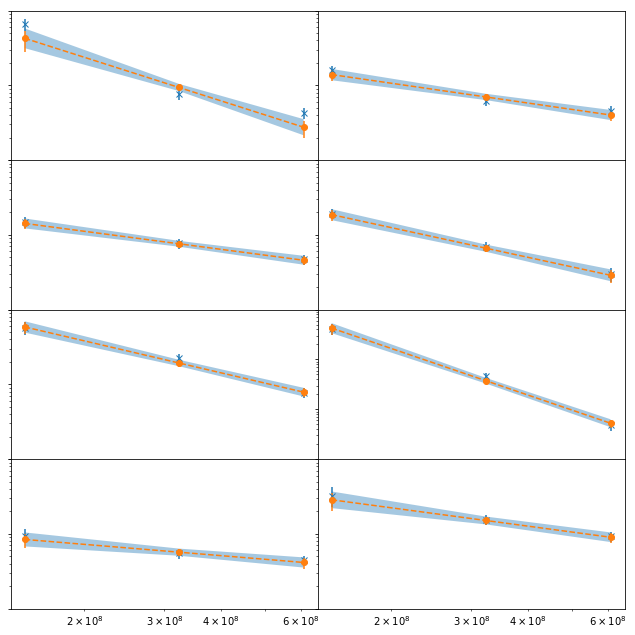

In [1]:
'''Compute the posterior estimates of spectral index, S1.4GHz, and P1.4GHz
as well as the posterior estimates of measured fluxes (S_i) using the Metropolis Hastings algorithm.
We assume priors: Gaussian measurments fluxes, uniform spectral index, uniform S1.4, and uniform P1.4.

Detection is defined as 5*sigma_rms. 
The detection mask can be defined to include nondetection measurements (a valid assumption for point sources).

The posterior density is then: prior x Likelihood (with priors described above).
The likelihood is an L2 on spectral index and S1.4 due to the Gaussian prior on observables.

Likelihood = exp(-1/2 * Sum (S_obs - g(alpha_i,S1.4))**2 / (Cd_i + Ct_i))

where S_obs are the measured fluxes
g(alpha_i,S1.4) gives model S_i
Cd_i is the measurement variance S_i
Ct_i is a systematic for g(...) taken to be (0.15*S_obs)**2

assuming z ~ 0.516 +- 0.002 we use the sampling of alpha and S14 to monte carlo compute the mean and variances of 
posterior S_i and P14 in lognormal as suggested by their posterior plots.

We find that the posterior distributions for:
alpha is Gaussian
S1.4 is lognormal
P1.4 is lognormal
S_i is lognormal
'''

import numpy as np
import pylab as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def g(alpha,S14,nu):
    '''Forward equation, evaluate model at given nu array'''
    out = S14*(nu/1400e6)**alpha
    return out

def L(Sobs,alpha,S14,nu,CdCt):
    '''Likeihood for alpha and S14'''
    #only as nu_obs
    d = g(alpha,S14,nu)
    L2 = np.sum((Sobs - d)**2/CdCt)
    #L1 = np.sum(np.abs(Sobs - d)/np.sqrt(CdCt))
    return np.exp(-L2/2.)

def P(nu,z,alpha,S14):
    c = 3e8
    h0 = 0.7
    ch = 1.32151838
    q0 = 0.5
    D = ch*z*(1+z*(1-q0)/(np.sqrt(1+2*q0*z) + 1 + q0*z))
    S = S14*(nu/1400e6)
    out = 4*np.pi*S*D**2 / (1+z)**(1+alpha) * 1e26
    return out/1e24

def MHSolveSpectealIndex(nu,S,Cd,Ct,name,z,dz,nuModel=None,plot=False,plotDir=None):
    '''Assumes S in mJy'''
    if nuModel is None:
        nuModel = nu
    if plotDir is not None:
        import os
        try:
            os.makedirs(plotDir)
        except:
            pass
    N = int(1e6)
    alpha_ = np.zeros(N,dtype=np.double)
    S14_ = np.zeros(N,dtype=np.double)
    alpha_[0] = -0.8
    S14_[0] = S[0]*(1400e6/nu[0])**-0.8
    print("Working on source {}".format(name))
    mask = detectionMask[idx,:]
    CdCt = Cd + Ct
    Li = L(S,alpha_[0],S14_[0],nu,CdCt)
    print("Initial L: {}".format(Li))
    maxL = Li
    alphaMAP = alpha_[0]
    S14MAP = S14_[0]
    accepted = 0
    binning = 50
    i = 1
    while accepted < binning*binning and i < N:
        #sample priors in uniform steps
        alpha_j = np.random.uniform(low=alpha_[i-1] - 0.5,high=alpha_[i-1] + 0.5)
        S14_j = 10**(np.random.uniform(low = np.log10(S14_[i-1]/100),high=np.log10(S14_[i-1]*100)))
        Lj = L(S,alpha_j,S14_j,nu,CdCt)
        if np.random.uniform() < Lj/Li:
            alpha_[i] = alpha_j
            S14_[i] = S14_j
            Li = Lj
            accepted += 1
        else:
            alpha_[i] = alpha_[i-1]
            S14_[i] = S14_[i-1]
        if Lj > maxL:
            maxL = Lj
            alphaMAP = alpha_j
            S14MAP = S14_j
        i += 1
    if accepted == binning**2:
        print("Converged in {} steps".format(i))
        print("Acceptance: {}, rate : {}".format(accepted,float(accepted)/i))
    else:
        print("Acceptance: {}, rate : {}".format(accepted,float(accepted)/i))
    alpha_ = alpha_[:i]
    S14_ = S14_[:i]    
    #integrate out uncertainty unsing MC integration
    logS_int = np.zeros([len(alpha_),len(nuModel)],dtype=np.double)
    logP14_int = np.zeros(len(alpha_),dtype=np.double)
    i = 0 
    while i < len(alpha_):
        logS_int[i,:] = np.log(g(alpha_[i],S14_[i],nuModel))
        logP14_int[i] = np.log(P(1400e6,np.random.normal(loc=z,scale=dz),alpha_[i],S14_[i]/1e3))
        i += 1
    logS_mu = np.mean(logS_int,axis=0)
    logS_std = np.sqrt(np.mean(logS_int**2,axis=0) - logS_mu**2)
    logP14_mu = np.mean(logP14_int)
    logP14_std = np.sqrt(np.mean(logP14_int**2) - logP14_mu**2)
    S_post_mu = np.exp(logS_mu)
    S_post_up = np.exp(logS_mu + logS_std) - S_post_mu
    S_post_low = S_post_mu - np.exp(logS_mu - logS_std)
    P14_post_mu = np.exp(logP14_mu)
    P14_post_up = np.exp(logP14_mu + logP14_std) - P14_post_mu
    P14_post_low = P14_post_mu - np.exp(logP14_mu- logP14_std)
    P14 = P14_post_mu
    P14u = P14_post_up
    P14l = P14_post_low
    alpha = np.mean(alpha_)
    std_alpha = np.std(alpha_)
    mu = np.exp(np.mean(np.log(S14_)))
    S14 = mu
    S14u = np.exp(np.mean(np.log(S14_)) + np.std(np.log(S14_))) - mu
    S14l = mu - np.exp(np.mean(np.log(S14_)) - np.std(np.log(S14_)))
    if plot:
        plt.hist(alpha_,bins=binning)
        plt.xlabel(r"$\alpha$")
        plt.ylabel(r"Count")
        plt.title("alpha")
        if plotDir is not None:
            plt.savefig("{}/{}-alpha-posterior.png".format(plotDir,name),format='png')
            plt.clf()
        else:
            plt.show()
        plt.hist(S14_,bins=binning)
        plt.xlabel(r"$S_{\rm 1.4GHz}[mJy]$")
        plt.ylabel(r"Count")
        plt.title("S14")
        if plotDir is not None:
            plt.savefig("{}/{}-S14-posterior.png".format(plotDir,name),format='png')
            plt.clf()
        else:
            plt.show() 
        plt.hist(np.log10(S14_),bins=binning)
        plt.xlabel(r"$\log_{10}{S_{\rm 1.4GHz}[mJy]}$")
        plt.ylabel(r"Count")
        plt.title("log(S14)")
        if plotDir is not None:
            plt.savefig("{}/{}-logS14-posterior.png".format(plotDir,name),format='png')
            plt.clf()
        else:
            plt.show()
    print("---------")
    print("Results for source {}".format(name))
    print("Max Likelihood: {}".format(maxL))
    print("alpha: {} +- {}".format(alpha,std_alpha))
    print("MAP alpha: {}".format(alphaMAP))
    print("S14: {} + {} - {} mJy".format(S14,S14u,S14l))  
    print("MAP S14: {} mJy".format(S14MAP))
    for fi in range(len(nuModel)):
        mu = S_post_mu[fi]
        up = S_post_up[fi]
        low = S_post_low[fi]
        print("(lognormal) S{}MHz: {} + {} - {} mJy".format(int(nuModel[fi]/1e6),mu,up,low)) 
    print("(lognormal) P14: {} + {} - {} mJy".format(P14_post_mu,
                                     P14_post_up, 
                                     P14_post_low))
    #plot the Gassuan model and data
    if plot:
        plt.errorbar(nu, S, yerr=np.sqrt(CdCt), fmt='x',label='data')
        plt.errorbar(nuModel, S_post_mu, yerr=[S_post_up,S_post_low], fmt='--o',label='model')
        plt.xlabel(r"$\nu$ [Hz]")
        plt.ylabel(r"$S(\nu)$ [mJy]")
        #plt.plot(nu,S_map,label='map')
        #plt.errorbar(nu, S_model, yerr=CdCt[idx,mask], fmt='--o')
        plt.legend()
        points = []
        for j in range(len(nuModel)):
            points.append((nuModel[j],S_post_mu[j] + S_post_up[j]))
            #points.append((nuModel[j],S_post_mu[j] - S_post_low[j]))
        for j in range(len(nuModel)):
            #points.append((nuModel[j],S_post_mu[j] + S_post_up[j]))
            points.append((nuModel[-j-1],S_post_mu[-j-1] - S_post_low[-j-1]))
            
        plt.gca().add_collection(PatchCollection([Polygon(points,True)],alpha=0.4))
        plt.yscale('log')
        plt.xscale('log')
        if plotDir is not None:
            plt.savefig("{}/{}-fluxes-posterior.png".format(plotDir,name),format='png')
            plt.clf()
        else:
            plt.show()
    print("--------")
    return alpha,std_alpha,S14,S14u,S14l,S_post_mu,S_post_up,S_post_low,P14_post_mu,P14_post_up,P14_post_low
    
if __name__ == '__main__':
    names = ['C1+2','NW1','NW2','H','E','X1','X2','S']
    nu = np.array([147.667e6,322.667e6,608.046e6])
    rms = np.array([1.4e-3,120e-6,90e-6])*1e3
    beams = np.array([43.3*18.9,17.5*9.5,7.2*4.9])*np.pi/4./np.log(2.)
    print("Beams: {} (arcsec^2)".format(beams))
    pixels = np.array([5.25**2,2**2,1.25**2])
    print("px/beam: {} (pixels)".format(beams/pixels))
    print("Uncertainty per px: {} mJy".format(rms*np.sqrt(pixels/beams)))
    #measurement mask
    detectionMask = np.bitwise_not(np.array([[0,0,0],
                  [0,0,0],
                 [0,0,0],
                 [0,0,0],
                 [0,0,0],
                 [0,0,0],
                 [0,0,0],
                 [0,0,0]],dtype=np.bool))
    #measurements
    S = np.array([[  66.034     ,    7.653     ,    4.241     ],
       [ 159.14      ,   62.206     ,   45.998     ],
       [ 147.575     ,   77.056     ,   46.834     ],
       [  10.40630611,    3.98776452,    1.16477836],
       [  57.346     ,   22.343     ,    7.6797    ],
       [  40.672     ,    4.556     ,    0.48076422],
       [   9.45811655,    5.508     ,    4.426     ],
       [  32.342     ,   15.314     ,    9.277     ]],dtype=np.double)
    std_d = np.array([[  6.58200000e+00,   2.94200000e-01,   3.12511200e-01],
       [  7.85100000e+00,   3.86200000e-01,   1.05200000e-01],
       [  8.11100000e+00,   3.54800000e-01,   3.58600000e-01],
       [  1.34408838e+00,   2.55608364e-01,   4.16152840e-01],
       [  7.16500000e+00,   3.11300000e-01,   2.90741019e-04],
       [  7.82100000e+00,   2.09200000e-01,   8.90090959e-02],
       [  1.40738833e+00,   2.27200000e-01,   2.34200000e-01],
       [  8.07500000e+00,   2.77200000e-01,   3.67694221e-01]],dtype=np.double)
    S = np.array([[66.034,7.653,2.357 + 1.884],#c12
                  [159.140,62.206,45.998],#nw1
                 [147.575,77.056,46.834],#nw2
                 [648.7*pixels[0]/beams[0],324.8*pixels[1]/beams[1],76.31*pixels[2]/beams[2]],#h
                 [57.346,22.343,(7.619+6.07E-2)],#e
                 [40.672,4.556,12.3*pixels[2]/beams[2]],#x1
                 [318.2*pixels[0]/beams[0],5.508,4.426],#x2
                 [32.342,15.314,3.744+5.533]],dtype=np.double)#s
    std_d = np.array([[6.582,2.942E-1,np.sqrt(2.086E-1**2 + 2.327E-1**2)],#c12
                 [7.851,3.862E-1,1.052E-1],#nw1
                 [8.111,3.548E-1,3.586E-1],#nw2
                 [rms[0]*np.sqrt(937.1/beams[0]),rms[1]*np.sqrt(928./beams[1]),rms[2]*np.sqrt(925./beams[2])],#h
                 [7.165,3.113E-1,np.sqrt(1.845E-4**2 + 2.247E-4**2)],#e
                 [7.821,2.092E-1,rms[2]*np.sqrt(39.1/beams[2])],#x1
                 [rms[0]*np.sqrt(937.1/beams[0]),2.272E-1,2.342E-1],#x2
                 [8.075,2.772E-1,np.sqrt(1.900E-1**2 + 3.148E-1**2)]],dtype=np.double)#s
    
    
    
    Cd = std_d**2
    Ct = (S*0.15)**2
    CdCt = Cd + Ct
    #previous estimates
    #alpha0 = np.array([-2.5501,-0.8804,-0.8458, -1.4624, -0.1102, -0.8988, -0.3312, -0.7236],dtype=np.double)
    #S140 = np.array([0.4034,20.5293, 23.2775, 0.113, 13.2874, 1.1842, 3.0169, 6.2674],dtype=np.double)
    #P0 = np.array([0.4,13,15,2.1,5.7,0.9,2.3,3.7],dtype=np.double)
    
    #samples    
    m = S.shape[0]
    #posterior moments
    alpha = np.zeros(m,dtype=np.double)
    std_alpha = np.zeros(m,dtype=np.double)
    S14 = np.zeros(m,dtype=np.double)
    S14u = np.zeros(m,dtype=np.double)
    S14l = np.zeros(m,dtype=np.double)
    P14 = np.zeros(m,dtype=np.double)
    P14u = np.zeros(m,dtype=np.double)
    P14l = np.zeros(m,dtype=np.double)
    S_post_mu = np.zeros([m,3],dtype=np.double)
    S_post_up = np.zeros([m,3],dtype=np.double)
    S_post_low = np.zeros([m,3],dtype=np.double)
    idx = 0
    while idx < m:
        mask = detectionMask[idx,:]
        alpha_,std_alpha_,S14_,S14u_,S14l_, S_post_mu_,S_post_up_,S_post_low_,P14_post_mu_,P14_post_up_,P14_post_low_ = MHSolveSpectealIndex(nu[mask],S[idx,mask],
                                                                                                                                             Cd[idx,mask],Ct[idx,mask],
                                                                                                                                             names[idx],0.516,0.002,nuModel=nu,plot=True,
                                                                                                                                            plotDir='spectral-figs') 
        alpha[idx] = alpha_
        std_alpha[idx] = std_alpha_
        S14[idx] = S14_
        S14u[idx] = S14u_
        S14l[idx] = S14l_
        S_post_mu[idx,:] = S_post_mu_
        S_post_up[idx,:] = S_post_up_
        S_post_low[idx,:] = S_post_low_
        P14[idx] = P14_post_mu_
        P14u[idx] = P14_post_up_
        P14l[idx] = P14_post_low_
        idx += 1
        
    i = 0
    while i < len(alpha):
        print(r"{} & ${:.2g} \pm {:.2g}$ & ${:.2g} \pm {:.2g}$ & ${:.2g} \pm {:.2g}$ & ${:.2g} \pm {:.2g}$ & ${:.2g}^{{{:.2g}}}_{{{:.2g}}}$ & ${:.2g}^{{{:.2g}}}_{{{:.2g}}}$\\".format(names[i],
                                                                                                  S[i,0],np.sqrt(CdCt[i,0]),
                                                                                                 S[i,1],np.sqrt(CdCt[i,1]),
                                                                                                 S[i,2],np.sqrt(CdCt[i,2]),
                                                                                                 alpha[i],std_alpha[i],
                                                                                                 S14[i],S14u[i],S14l[i],
                                                                                                 P14[i],P14u[i],P14l[i]))
        i += 1
    f, axs = plt.subplots(4,2,sharex=True,figsize=(11,11))
    cols= 2
    rows = 4
    i=0
    while i < len(alpha):
        #i = row*2 + col
        col = i%cols
        row = (i - col)//cols
        if rows == 1:
            if cols == 1:
                ax = axs
            else:
                ax = axs[col]
        else:
            ax = axs[row][col]
        mask = detectionMask[i,:]
        mask[:] = True
        ax.errorbar(nu[mask], S[i,mask], yerr=np.sqrt(CdCt[i,mask]), fmt='x',label='data')
        ax.errorbar(nu, S_post_mu[i,:], yerr=[S_post_up[i,:],S_post_low[i,:]], fmt='--o',label='model')
        points = []
        for j in range(len(nu)):
            points.append((nu[j],S_post_mu[i,j] + S_post_up[i,j]))
            #points.append((nuModel[j],S_post_mu[j] - S_post_low[j]))
        for j in range(len(nu)):
            #points.append((nuModel[j],S_post_mu[j] + S_post_up[j]))
            points.append((nu[-j-1],S_post_mu[i,-j-1] - S_post_low[i,-j-1]))
            
        ax.add_collection(PatchCollection([Polygon(points,True)],alpha=0.4))

        #ax.set_ylim([])
        ax.set_yscale('log')
        ax.set_xscale('log')
        ylims = list(ax.get_ylim())
        ylims[0] = 10**(np.floor(np.log10(ylims[0])))
        ylims[1] = 10**(np.ceil(np.log10(ylims[1])))
        print(ylims)
        ax.set_ylim(ylims)
        ax.set_xticks([])#('right')
        ax.set_xticklabels([])
        if col==1:
            ax.yaxis.set_label_position('right')
        i += 1
    #axs[-1][0].set_xlabel(r'$\nu$ [Hz]')
    #axs[-1][1].set_xlabel(r'$\nu$ [Hz]')
    #axs[4>>1][0].set_ylabel(r'$S(\nu)$ [mJy]')
    f.subplots_adjust(hspace=0,wspace=0)

    plt.setp([ax.get_xticklabels() for ax in f.axes],visible=False)
    plt.setp([ax.get_yticklabels() for ax in f.axes],visible=False)
    plt.show()

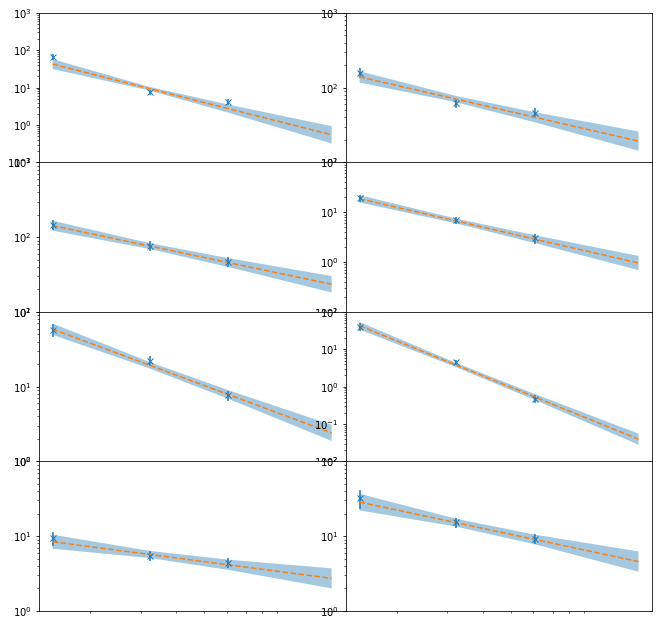

In [23]:
def plotSpectrum(nu,S,CdCt,S_post_mu,S_post_up,S_post_low, mask, ax):
    ax.errorbar(nu[mask], S[mask], yerr=np.sqrt(CdCt[mask]), fmt='x',label='data')
    #ax.errorbar(nu, S_post_mu, yerr=[S_post_up,S_post_low], fmt='--o',label='model')
    ax.plot(nu, S_post_mu, ls='--',label='model')
    points = []
    for j in range(len(nu)):
        points.append((nu[j],S_post_mu[j] + S_post_up[j]))
        #points.append((nuModel[j],S_post_mu[j] - S_post_low[j]))
    for j in range(len(nu)):
        #points.append((nuModel[j],S_post_mu[j] + S_post_up[j]))
        points.append((nu[-j-1],S_post_mu[-j-1] - S_post_low[-j-1]))

    ax.add_collection(PatchCollection([Polygon(points,True)],alpha=0.4))

    #ax.set_ylim([])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ylims = list(ax.get_ylim())
    ylims[0] = 10**(np.floor(np.log10(ylims[0])))
    ylims[1] = 10**(np.ceil(np.log10(ylims[1])))
    ax.set_ylim(ylims)
    ax.set_xticks([])#('right')
    ax.set_xticklabels([])
    
f, axs = plt.subplots(4,2,sharex=True,figsize=(11,11))
cols= 2
rows = 4
i=0
while i < len(alpha):
    #i = row*2 + col
    col = i%cols
    row = (i - col)//cols
    if rows == 1:
        if cols == 1:
            ax = axs
        else:
            ax = axs[col]
    else:
        ax = axs[row][col]
    #plt.figure()
    #ax = plt.subplot(111)
    mask = detectionMask[i,:]
    mask[:] = True
    plotSpectrum(np.append(nu,1400e6),np.append(S[i,:],0),np.append(CdCt[i,:],0),np.append(S_post_mu[i,:],S14[i]),
                 np.append(S_post_up[i,:],S14u[i]),np.append(S_post_low[i,:],S14l[i]),np.append(mask,False), ax)
    if col==1:
        ax.yaxis.set_label_position('right')
    i += 1
#axs[-1][0].set_xlabel(r'$\nu$ [Hz]')
#axs[-1][1].set_xlabel(r'$\nu$ [Hz]')
#axs[4>>1][0].set_ylabel(r'$S(\nu)$ [mJy]')
f.subplots_adjust(hspace=0,wspace=0)

#plt.setp([ax.get_xticklabels() for ax in f.axes],visible=False)
#plt.setp([ax.get_yticklabels() for ax in f.axes],visible=False)
plt.show()